## Sales Forecasting Challenge - Modeling with Exogenous Variable

In [1]:
# import all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [3]:
# read csv file and store it into a dataframe
df = pd.read_csv("2. train_sales_forecast.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.IsHoliday = df.IsHoliday.astype(int)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,25037.08,0
1,1,1,2010-02-12,46247.44,1
2,1,1,2010-02-19,41783.43,0
3,1,1,2010-02-26,19491.18,0
4,1,1,2010-03-05,21926.49,0


In [4]:
df_train = df[df.Date <= pd.to_datetime("2011-10-31")].reset_index(drop=True)
df_val = df[(df.Date >= pd.to_datetime("2011-11-01")) & (df.Date <= pd.to_datetime("2012-01-31"))].reset_index(drop=True)
df_test = df[(df.Date >= pd.to_datetime("2012-02-01")) & (df.Date <= pd.to_datetime("2012-04-30"))].reset_index(drop=True)
df_train_val = df[df.Date <= pd.to_datetime("2012-01-31")].reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape, df_train_val.shape

((65332, 5), (9379, 5), (9345, 5), (74711, 5))

In [5]:
def impute_missing_rows(df):
    """
    This function imputes missing rows to the dataframe to make it evenly spaned.

    Parameters:
    df: The pandas DataFrame object

    Returns:
    df: The pandas DataFrame object after imputation
    """
    print(f"Shape of dataframe before imputation: {df.shape}")
    # get minimum and maximum dates from the entire dataframe
    end_date = df.Date.max()
    start_date = df.Date.min()
    # get all the unique stores in the dataframe
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        # get all the departments from that store
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            # start_date = df_store_dept.Date.min()
            current_date = start_date
            while current_date <= end_date:
                # if a date is not present, impute it with Zero sales
                if current_date not in df_store_dept.Date.values:
                    # print([store_no, dept_no, current_date])
                    try:
                        # get the holiday information of the missing date from the entire df
                        is_holiday = df[df.Date == current_date]['IsHoliday'].values[0]
                    except:
                        print("Date not present in the entire dataframe, considering False")
                        is_holiday = False
                    df.loc[len(df)] = [store_no, dept_no, current_date, 0, is_holiday]
                current_date += timedelta(days=7)
    print(f"Shape of dataframe after imputation: {df.shape}")
    return df

In [6]:
def preprocess_dataframe(df):
    """
    This function preprocess the data before training.

    Parameters:
    df: The pandas DataFrame object

    Returns:
    df: The pandas DataFrame object after preprocessing
    """
    # impute missing rows in the dataframe
    df = impute_missing_rows(df)
    df.IsHoliday = df.IsHoliday.astype(int)
    return df

In [7]:
def filter_dataframe(df, store, dept):
    """
    This function filters dataframe based on store no and department.

    Parameters:
    df: The pandas DataFrame object
    store: Store number
    dept: Deparrtment number

    Returns:
    df: The pandas DataFrame object after filtering based on store and dept
    """
    df = df[(df['Store'] == store) & (df['Dept'] == dept)]
    return df

In [8]:
# preprocess the dataframe before statistical tests and training
df_train = preprocess_dataframe(df_train)

Shape of dataframe before imputation: (65332, 5)
Shape of dataframe after imputation: (69706, 5)


In [9]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,25037.08,0
1,1,1,2010-02-12,46247.44,1
2,1,1,2010-02-19,41783.43,0
3,1,1,2010-02-26,19491.18,0
4,1,1,2010-03-05,21926.49,0


#### ARIMA Model with Exogenous Variable (Holiday)

In [10]:
def fit_arima_model_exogenous(df, order):
    """
    This function fits ARIMA model

    Parameters:
    df: dataframe object
    order: (p, d, q)

    Returns:
    fitted model object
    """
    # Ensure the data is sorted by date
    df = df.sort_values(by='Date')
     # Set the date as index and set the frequency Weekly-Friday (Dates are of Friday)
    df = df.set_index('Date').asfreq('W-FRI')
   
    # Fit the ARIMA model
    model = ARIMA(df['Weekly_Sales'], exog=df['IsHoliday'],order=order)
    model_fit = model.fit()
    
    return model_fit

In [11]:
def train_arima_model_exogenous(df, order):
    """
    This function trains every series of the dataframe.
    Parameters:
    df: dataframe object
    order: (p, d, q)

    Returns:
    Dictionary containing fitted models with key tuple(store, dept) and value model object
    """
    models_dict = {}
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            try:
                model_fit = fit_arima_model_exogenous(df_store_dept, order)
                models_dict[(store_no, dept_no)] = model_fit
            except Exception as e:
                print(f'Failed to fit ARIMA model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [12]:
def validate_arima_model_exogenous(df_train, df_val, models_dict, forecast_steps):
    predicted_arima_df = pd.DataFrame()
    val_holidays = df_val[['Date', 'IsHoliday']].drop_duplicates().sort_values(by='Date')
    for store_no in df_train.Store.unique():
        df_store = df_train[df_train.Store == store_no]
        for dept_no in df_store.Dept.unique():
            forecast = models_dict[(store_no, dept_no)].get_forecast(steps=forecast_steps, exog=val_holidays.IsHoliday)
            forecast_df = forecast.summary_frame()
            forecast_df = forecast_df[['mean']]
            forecast_df['Store'] = store_no
            forecast_df['Dept'] = dept_no
            predicted_arima_df  = pd.concat([predicted_arima_df, forecast_df], ignore_index=False)
    predicted_arima_df = predicted_arima_df.reset_index()
    predicted_arima_df = predicted_arima_df.rename(columns={'index': 'Date', 'mean': 'Weekly_Sales_Predicted'})
    predicted_arima_df = predicted_arima_df.reset_index(drop=True)

    # merge the predicted forecast with df_val
    df_merged_predicted_sales = pd.merge(df_val, predicted_arima_df, on=['Store', 'Dept', 'Date'], how='left')
    return df_merged_predicted_sales

In [13]:
# this method computes MAPE for a dataframe based on actual and forecasted value
def mean_absolute_percentage_error(df):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)

    Parameters:
    df: dataframe object

    Returns:
    float: MAPE value
    """
    df = df.dropna()
    y_true = df['Weekly_Sales']
    y_pred = df['Weekly_Sales_Predicted']
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Exclude cases where y_true is zero to avoid division by zero
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    if len(y_true_non_zero) == 0:
        raise ValueError("All true values are zero, MAPE cannot be computed.")
    
    return np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero))

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
# considering p, d, q = (1, 1, 1)
arima_trained_models_dict_exogen = train_arima_model_exogenous(df_train, order=(1,1,1))
validation_forecasted_arima_exogen_df = validate_arima_model_exogenous(df_train, df_val, arima_trained_models_dict_exogen, forecast_steps=13)
mape_score_arima_exogen_val = round(mean_absolute_percentage_error(validation_forecasted_arima_exogen_df), 4)
print(f"Validation Score for ARIMA with Exogenous model is {mape_score_arima_exogen_val}")

Validation Score for ARIMA with Exogenous model is 0.3828


#### Now Retrain the model with train + val data for test prediction

In [17]:
# preprocess the dataframe before statistical tests and training
df_train_val = preprocess_dataframe(df_train_val)

Shape of dataframe before imputation: (74711, 5)
Shape of dataframe after imputation: (80808, 5)


In [19]:
arima_trained_models_dict_exogen = train_arima_model_exogenous(df_train_val, order=(1,1,1))
test_forecasted_arima_exogen_df = validate_arima_model_exogenous(df_train_val, df_test, arima_trained_models_dict_exogen, forecast_steps=13)
mape_score_arima_test = round(mean_absolute_percentage_error(test_forecasted_arima_exogen_df), 4)
print(f"Test Score for ARIMA model is {mape_score_arima_test}")

Test Score for ARIMA model is 4.4527


In [63]:
!pip install beautifultable
from beautifultable import BeautifulTable

In [22]:
# taken the MAPE scores of previous model for comparison
table = BeautifulTable() 
table.column_headers= ["Model Name", "Validation MAPE", "Test MAPE"]
table.append_row(["ARIMA", "0.3808", "4.7725"])
table.append_row(["SARIMAX", "0.4169", "12.1021"])
table.append_row(["PROPHET", "0.452", "23.2319"])
table.append_row(["ARIMA+Exogen", "0.3828", "4.4527"])
print(table)

+--------------+-----------------+-----------+
|  Model Name  | Validation MAPE | Test MAPE |
+--------------+-----------------+-----------+
|    ARIMA     |      0.381      |   4.772   |
+--------------+-----------------+-----------+
|   SARIMAX    |      0.417      |  12.102   |
+--------------+-----------------+-----------+
|   PROPHET    |      0.452      |  23.232   |
+--------------+-----------------+-----------+
| ARIMA+Exogen |      0.383      |   4.453   |
+--------------+-----------------+-----------+


#### Plot Original and Predicted Sales for Test Data

In [24]:
def plot_original_and_predicted_data(df, col1='Weekly_Sales', col2='Weekly_Sales_Predicted'):
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='Date', y=col1, label='Original')
    sns.lineplot(data=df, x='Date', y=col2, label='Predicted')
    
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.title('Original vs Predicted Weekly Sales Forecasts')
    plt.legend()
    plt.show()

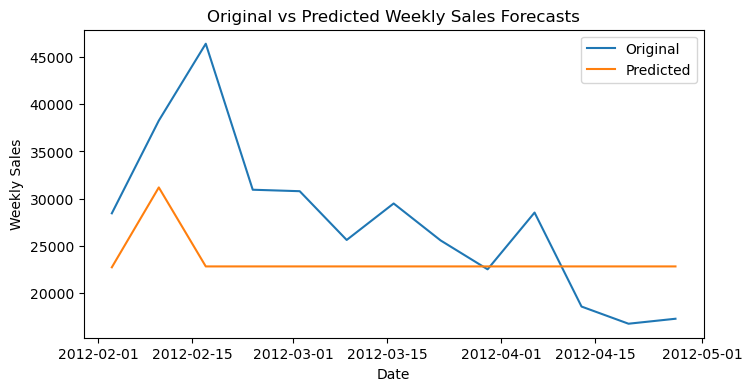

In [25]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_exogen_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

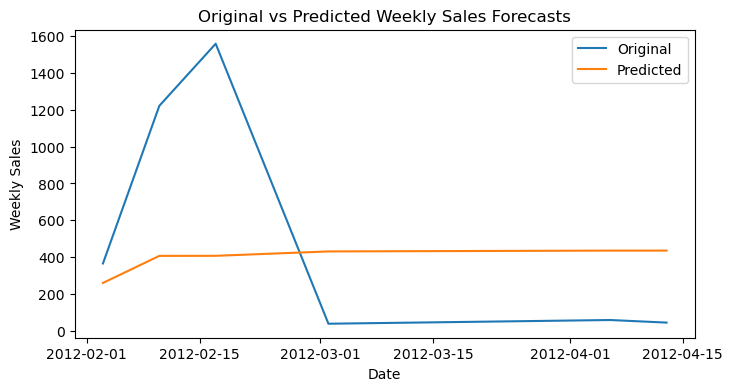

In [26]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_exogen_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

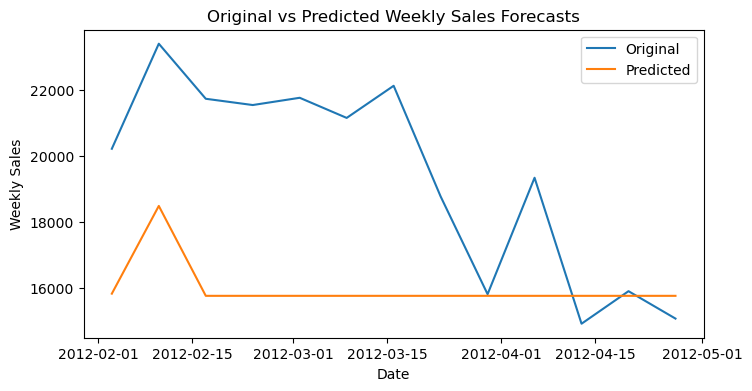

In [27]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_exogen_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

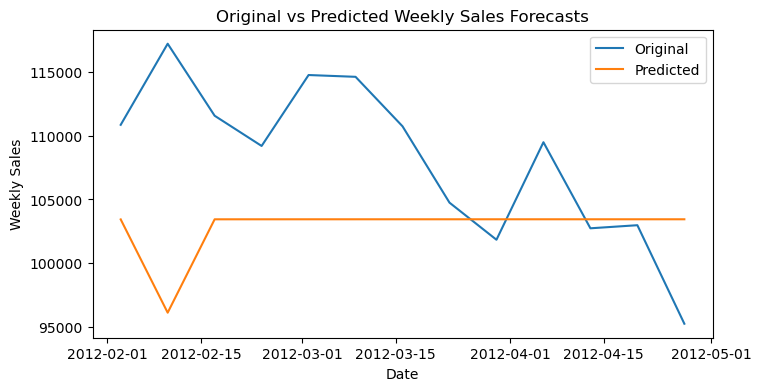

In [28]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_exogen_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

#### SARIMAX Model with Exogenous Variable (Holiday)

In [29]:
def fit_sarimax_model_exogenous(df, order, seasonal_order):
    """
    This function fits SARIMAX model

    Parameters:
    df: dataframe object
    order: (p, d, q)
    seasonal_order = (p, d, q, s)

    Returns:
    fitted model object
    """
    # Ensure the data is sorted by date
    df = df.sort_values(by='Date')
     # Set the date as index and set the frequency Weekly-Friday (Dates are of Friday)
    df = df.set_index('Date').asfreq('W-FRI')
   
    # Fit the SARIMAX model
    model = SARIMAX(df['Weekly_Sales'], exog=df['IsHoliday'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    return model_fit

In [30]:
def train_sarimax_model_exogenous(df, order, seasonal_order):
    """
    This function trains every series of the dataframe.
    Parameters:
    df: dataframe object
    order: (p, d, q)
    seasonal_order = (p, d, q, s)
    
    Returns:
    Dictionary containing fitted models with key tuple(store, dept) and value model object
    """
    models_dict = {}
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            try:
                model_fit = fit_sarimax_model_exogenous(df_store_dept, order, seasonal_order)
                models_dict[(store_no, dept_no)] = model_fit
            except Exception as e:
                print(f'Failed to fit SARIMAX model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [31]:
def validate_sarimax_model_exogenous(df_train, df_val, models_dict, forecast_steps):
    predicted_sarimax_df = pd.DataFrame()
    val_holidays = df_val[['Date', 'IsHoliday']].drop_duplicates().sort_values(by='Date')
    for store_no in df_train.Store.unique():
        df_store = df_train[df_train.Store == store_no]
        for dept_no in df_store.Dept.unique():
            forecast = models_dict[(store_no, dept_no)].get_forecast(steps=forecast_steps, exog=val_holidays.IsHoliday)
            forecast_df = forecast.summary_frame()
            forecast_df = forecast_df[['mean']]
            forecast_df['Store'] = store_no
            forecast_df['Dept'] = dept_no
            predicted_sarimax_df  = pd.concat([predicted_sarimax_df, forecast_df], ignore_index=False)
    predicted_sarimax_df = predicted_sarimax_df.reset_index()
    predicted_sarimax_df = predicted_sarimax_df.rename(columns={'index': 'Date', 'mean': 'Weekly_Sales_Predicted'})
    predicted_sarimax_df = predicted_sarimax_df.reset_index(drop=True)

    # merge the predicted forecast with df_val
    df_merged_predicted_sales = pd.merge(df_val, predicted_sarimax_df, on=['Store', 'Dept', 'Date'], how='left')
    return df_merged_predicted_sales

In [35]:
# considering monthly seasonal order for sarimax, i.e. 4 weeks
sarimax_trained_models_dict_exogen = train_sarimax_model_exogenous(df_train, order=(1,1,1), seasonal_order=(1,1,1,4))
validation_forecasted_sarimax_exogen_df = validate_sarimax_model_exogenous(df_train, df_val, sarimax_trained_models_dict_exogen, forecast_steps=13)
mape_score_sarimax_val = round(mean_absolute_percentage_error(validation_forecasted_sarimax_exogen_df), 4)
print(f"Validation Score for SARIMAX model is {mape_score_sarimax_val}")

Validation Score for SARIMAX model is 0.4257


In [42]:
# check the performance on test data after training on train + val data
# considering monthly seasonal order for sarimax, i.e. 4 weeks
sarimax_trained_models_dict_exogen = train_sarimax_model_exogenous(df_train_val, order=(1,1,1), seasonal_order=(1,1,1,4))
test_forecasted_sarimax_exogen_df = validate_sarimax_model_exogenous(df_train_val, df_test, sarimax_trained_models_dict_exogen, forecast_steps=13)
mape_score_sarimax_test = round(mean_absolute_percentage_error(test_forecasted_sarimax_exogen_df), 4)
print(f"Test Score for SARIMAX model is {mape_score_sarimax_test}")

Test Score for SARIMAX model is 16.8132


In [43]:
table.append_row(["SARIMAX+Exogen", "0.4257", "16.8132"])
print(table)

+----------------+-----------------+-----------+
|   Model Name   | Validation MAPE | Test MAPE |
+----------------+-----------------+-----------+
|     ARIMA      |      0.381      |   4.772   |
+----------------+-----------------+-----------+
|    SARIMAX     |      0.417      |  12.102   |
+----------------+-----------------+-----------+
|    PROPHET     |      0.452      |  23.232   |
+----------------+-----------------+-----------+
|  ARIMA+Exogen  |      0.383      |   4.453   |
+----------------+-----------------+-----------+
| SARIMAX+Exogen |      0.426      |  16.813   |
+----------------+-----------------+-----------+


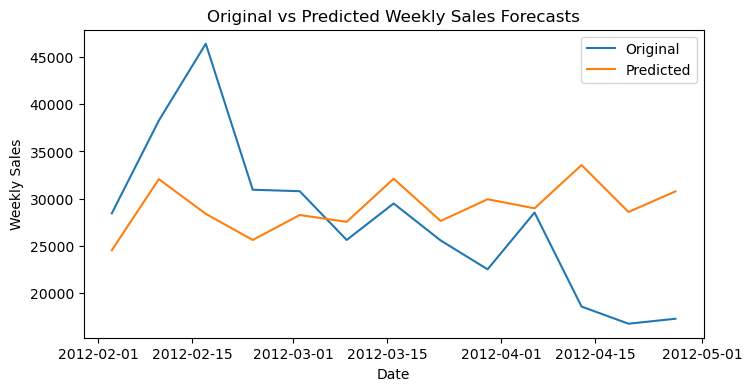

In [44]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_exogen_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

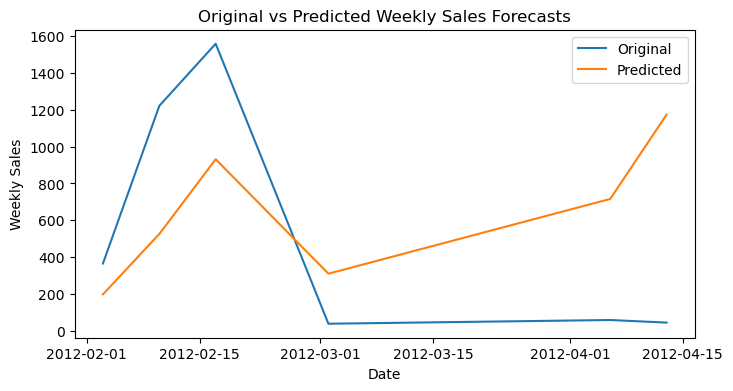

In [45]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_exogen_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

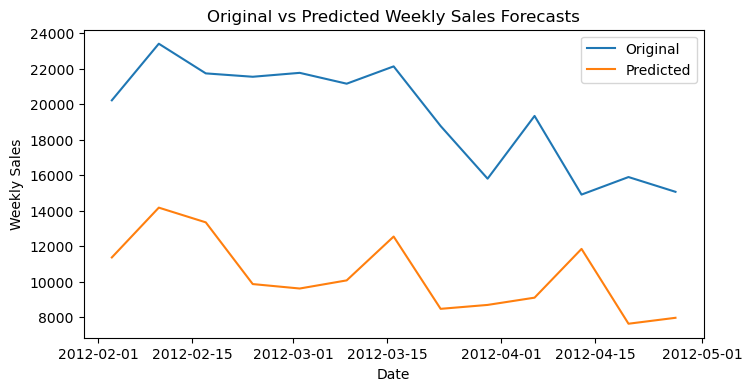

In [46]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_exogen_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

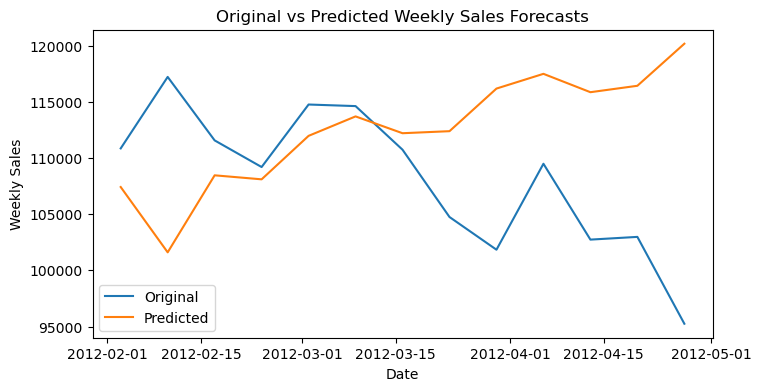

In [47]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_exogen_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

#### Prophet Model with Exogenous Variable (Holidays)

In [48]:
def fit_prophet_model_exogenous(df, holidays):
    """
    This function fits PROPHET model
    """
    df = df.sort_values(by='Date')
    df = df[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
    model = Prophet(holidays=holidays)
    model.fit(df)
    return model

In [49]:
def prepare_prophet_holidays(df):
    holiday_df = df[['Date', 'IsHoliday']]
    holiday_df = holiday_df.drop_duplicates()
    
    # Filter only holidays
    holiday_weeks = holiday_df[holiday_df['IsHoliday'] == True]['Date']
    
    # Create the holidays DataFrame for Prophet
    prophet_holidays = pd.DataFrame({
        'holiday': 'holiday',
        'ds': pd.to_datetime(holiday_weeks),
        'lower_window': 0,
        'upper_window': 1,
    })
    return prophet_holidays

In [50]:
def train_prophet_model_exogenous(df):
    """
    This function trains every series of the dataframe.
    """
    models_dict = {}
    prophet_holidays = prepare_prophet_holidays(df)
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            try:
                model_fit = fit_prophet_model_exogenous(df_store_dept, prophet_holidays)
                models_dict[(store_no, dept_no)] = model_fit
            except Exception as e:
                print(f'Failed to fit PROPHET model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [51]:
def validate_prophet_model_exogenous(df_train, df_val, models_dict, forecast_steps):
    predicted_prophet_df = pd.DataFrame()
    holiday_val = df_val[['Date', 'IsHoliday']]
    holiday_val = holiday_val.drop_duplicates()
    holiday_val = holiday_val[holiday_val['IsHoliday'] == True]['Date']
    
    for store_no in df_train.Store.unique():
        df_store = df_train[df_train.Store == store_no]
        for dept_no in df_store.Dept.unique():
            model = models_dict[(store_no, dept_no)]
            future = model.make_future_dataframe(periods=forecast_steps, freq='7D')
            # Add holiday indicators to the future DataFrame
            future['IsHoliday'] = future['ds'].isin(holiday_val).astype(int)
            forecast = model.predict(future)
            forecast = forecast[['ds', 'yhat']]
            forecast['Store'] = store_no
            forecast['Dept'] = dept_no
            predicted_prophet_df  = pd.concat([predicted_prophet_df, forecast], ignore_index=False)
    predicted_prophet_df = predicted_prophet_df.reset_index()
    predicted_prophet_df = predicted_prophet_df.rename(columns={'ds': 'Date', 'yhat': 'Weekly_Sales_Predicted'})
    predicted_prophet_df = predicted_prophet_df.reset_index(drop=True)
    predicted_prophet_df = predicted_prophet_df.drop('index', axis=1)

    # merge the predicted forecast with df_val
    df_merged_predicted_sales = pd.merge(df_val, predicted_prophet_df, on=['Store', 'Dept', 'Date'], how='left')
    return df_merged_predicted_sales

In [53]:
prophet_trained_models_exogen_dict = train_prophet_model_exogenous(df_train)
validation_forecasted_prophet_exogen_df = validate_prophet_model_exogenous(df_train, df_val, prophet_trained_models_exogen_dict, forecast_steps=13)
mape_score_prophet_val = round(mean_absolute_percentage_error(validation_forecasted_prophet_exogen_df), 4)
print(f"Validation Score for PROPHET model is {mape_score_prophet_val}")

Validation Score for PROPHET model is 0.458


In [55]:
val_holidays = df_test[['Date', 'IsHoliday']].drop_duplicates().sort_values(by='Date')
print(f"Forecast Steps: {len(val_holidays)}")

Forecast Steps: 13


In [57]:
prophet_trained_models_exogen_dict = train_prophet_model_exogenous(df_train_val)
test_forecasted_prophet_exogen_df = validate_prophet_model_exogenous(df_train_val, df_test, prophet_trained_models_exogen_dict, forecast_steps=13)
mape_score_prophet_test = round(mean_absolute_percentage_error(test_forecasted_prophet_exogen_df), 4)
print(f"Test Score for PROPHET model is {mape_score_prophet_test}")

Test Score for PROPHET model is 20.7046


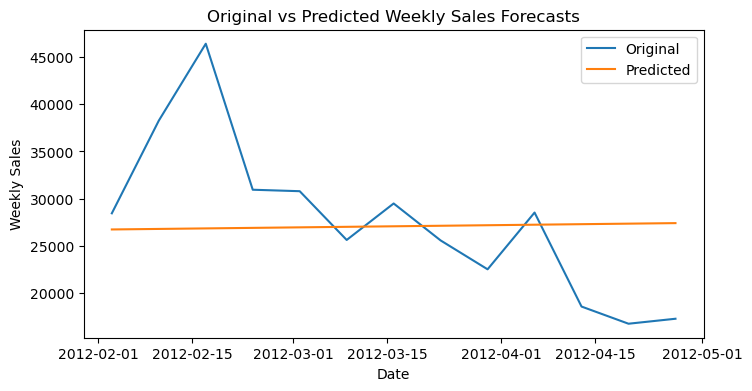

In [58]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_exogen_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

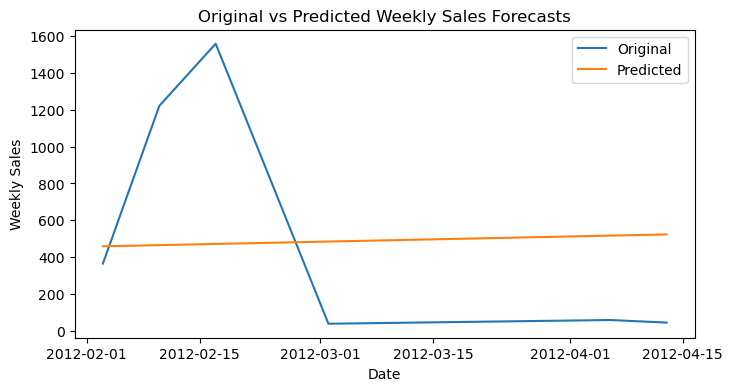

In [59]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_exogen_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

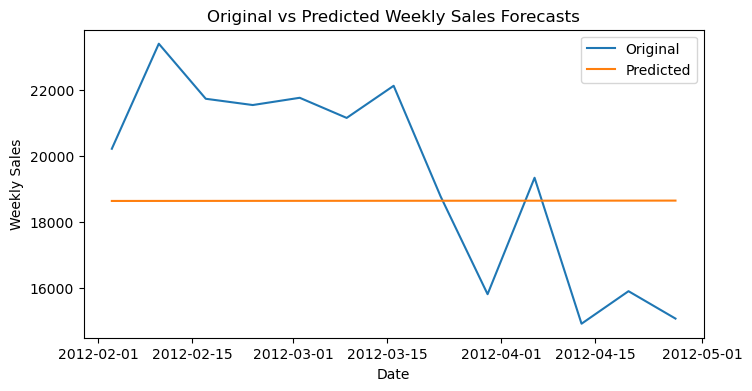

In [60]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_exogen_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

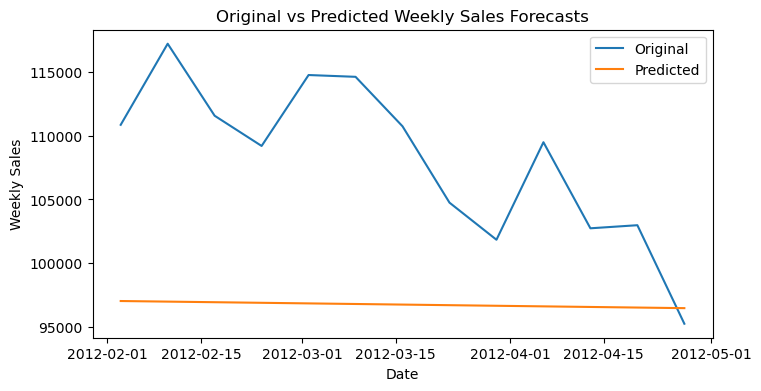

In [61]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_exogen_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

In [62]:
table.append_row(["PROPHET+Exogen", "0.458", "20.7046"])
print(table)

+----------------+-----------------+-----------+
|   Model Name   | Validation MAPE | Test MAPE |
+----------------+-----------------+-----------+
|     ARIMA      |      0.381      |   4.772   |
+----------------+-----------------+-----------+
|    SARIMAX     |      0.417      |  12.102   |
+----------------+-----------------+-----------+
|    PROPHET     |      0.452      |  23.232   |
+----------------+-----------------+-----------+
|  ARIMA+Exogen  |      0.383      |   4.453   |
+----------------+-----------------+-----------+
| SARIMAX+Exogen |      0.426      |  16.813   |
+----------------+-----------------+-----------+
| PROPHET+Exogen |      0.458      |  20.705   |
+----------------+-----------------+-----------+


## Conclusion:
Holiday parameter has impact on modeling. It has reduced test MAPE score for ARIMA and PROPHET model. ARIMA model with Holiday calender is the best model so far as it's validation MAPE is low and Test MAPE is lowest among all.